In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

/home/qazw5741/miniconda3/envs/SAM/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [4]:
from pycocotools.coco import COCO
import os.path as osp
#db = COCO(osp.join('/database/changhee/MSCOCO/annotations', 'person_keypoints_' + "train" + '2017.json'))
db = COCO(osp.join('/database/changhee/MPII', 'annotations', 'train.json'))

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/qazw5741/segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [80]:
num=1
for iid in db.imgs.keys():
    num+=1
    aids = db.getAnnIds([iid])

    joints=[]
    for aid in aids:
        ann = db.anns[aid]
        img = db.loadImgs(ann['image_id'])[0]
        img_path = osp.join('/database/changhee/MPII', img['file_name'])
        joint_img = np.array(ann['keypoints'], dtype=np.float32).reshape(-1, 3)
        joints.append(joint_img)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if num==55:
        break
joints=np.array(joints)

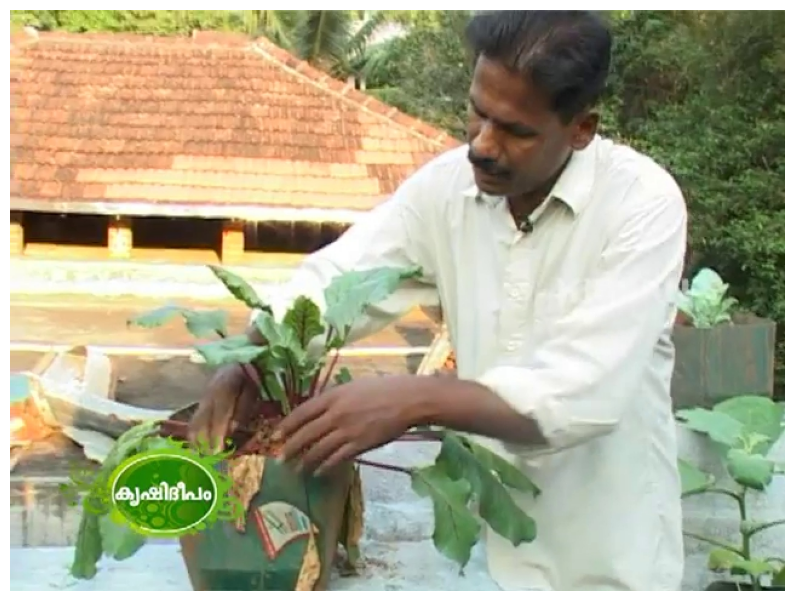

In [81]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.savefig("./assets/MPII_input1.jpg",bbox_inches='tight', pad_inches=0)
plt.show()

In [82]:
predictor.set_image(image)

In [83]:
joints

array([[[  0.    ,   0.    ,   0.    ],
        [  0.    ,   0.    ,   0.    ],
        [379.    , 327.    ,   1.    ],
        [506.    , 371.    ,   1.    ],
        [  0.    ,   0.    ,   0.    ],
        [  0.    ,   0.    ,   0.    ],
        [443.    , 349.    ,   1.    ],
        [446.    , 135.    ,   1.    ],
        [450.0434, 152.8844,   1.    ],
        [415.9566,   2.1156,   1.    ],
        [201.    , 280.    ,   1.    ],
        [266.    , 209.    ,   1.    ],
        [367.    , 128.    ,   1.    ],
        [524.    , 141.    ,   1.    ],
        [483.    , 321.    ,   1.    ],
        [339.    , 320.    ,   1.    ]]], dtype=float32)

In [84]:
test_j=joints[0]
new_j=[]
for i in test_j:
    if i[2]!=0:
        new_j.append(i)
new_j=np.array(new_j)
print(new_j)

[[379.     327.       1.    ]
 [506.     371.       1.    ]
 [443.     349.       1.    ]
 [446.     135.       1.    ]
 [450.0434 152.8844   1.    ]
 [415.9566   2.1156   1.    ]
 [201.     280.       1.    ]
 [266.     209.       1.    ]
 [367.     128.       1.    ]
 [524.     141.       1.    ]
 [483.     321.       1.    ]
 [339.     320.       1.    ]]


In [85]:
new_j[:,2]=1

In [86]:
input_point = new_j[:,:2]
input_label = new_j[:,2]

In [87]:
input_point

array([[379.    , 327.    ],
       [506.    , 371.    ],
       [443.    , 349.    ],
       [446.    , 135.    ],
       [450.0434, 152.8844],
       [415.9566,   2.1156],
       [201.    , 280.    ],
       [266.    , 209.    ],
       [367.    , 128.    ],
       [524.    , 141.    ],
       [483.    , 321.    ],
       [339.    , 320.    ]], dtype=float32)

In [88]:
input_label

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

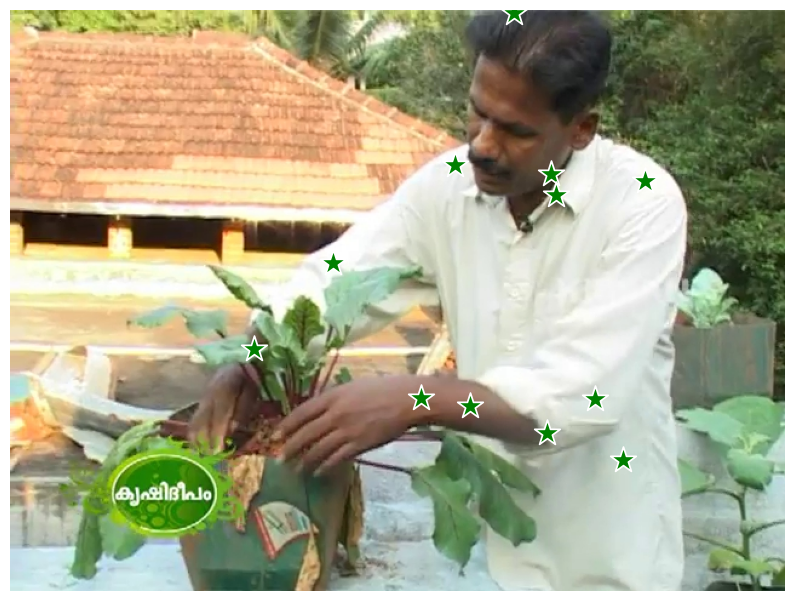

In [89]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.savefig("./assets/MPII_2d_input1.jpg",bbox_inches='tight', pad_inches=0)
plt.show()  

In [90]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [91]:
masks.shape

(3, 480, 640)

In [92]:
scores

array([0.8150482 , 0.9751208 , 0.97753775], dtype=float32)

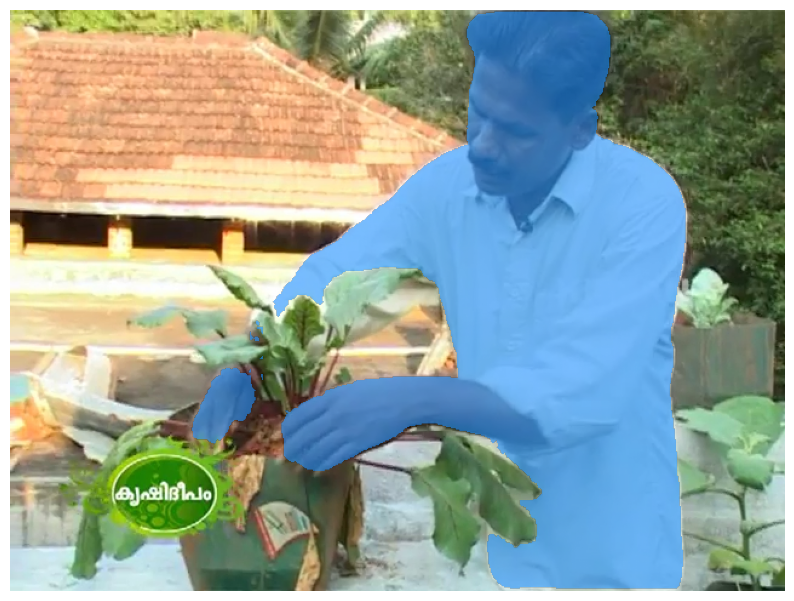

In [94]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[2], plt.gca())
#show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.savefig("./assets/MPII_mask1.jpg",bbox_inches='tight', pad_inches=0)
plt.show() 

In [17]:
from pycocotools.coco import COCO
from pycocotools import mask


In [18]:
test=mask.encode(np.asfortranarray(masks[2]))

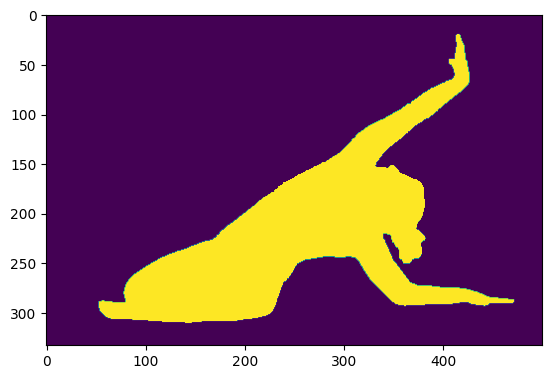

In [19]:
plt.imshow(mask.decode(test))

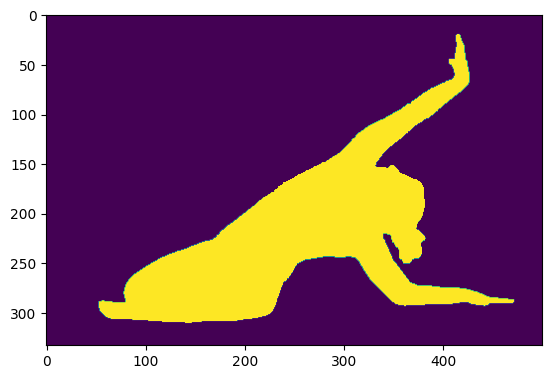

In [20]:
test['counts']=test['counts'].decode('utf-8')
plt.imshow(mask.decode(test))